In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
df =pd.read_csv('AUINSA.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,AUINSA
DATE,
1993-01-01,1315.7
1993-02-01,1387.4
1993-03-01,1420.9
1993-04-01,1426.3
1993-05-01,1432.0


In [4]:
df.index

DatetimeIndex(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01',
               '1993-05-01', '1993-06-01', '1993-07-01', '1993-08-01',
               '1993-09-01', '1993-10-01',
               ...
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01'],
              dtype='datetime64[ns]', name='DATE', length=349, freq=None)

In [5]:
df.index.freq = 'MS'

<Axes: xlabel='DATE'>

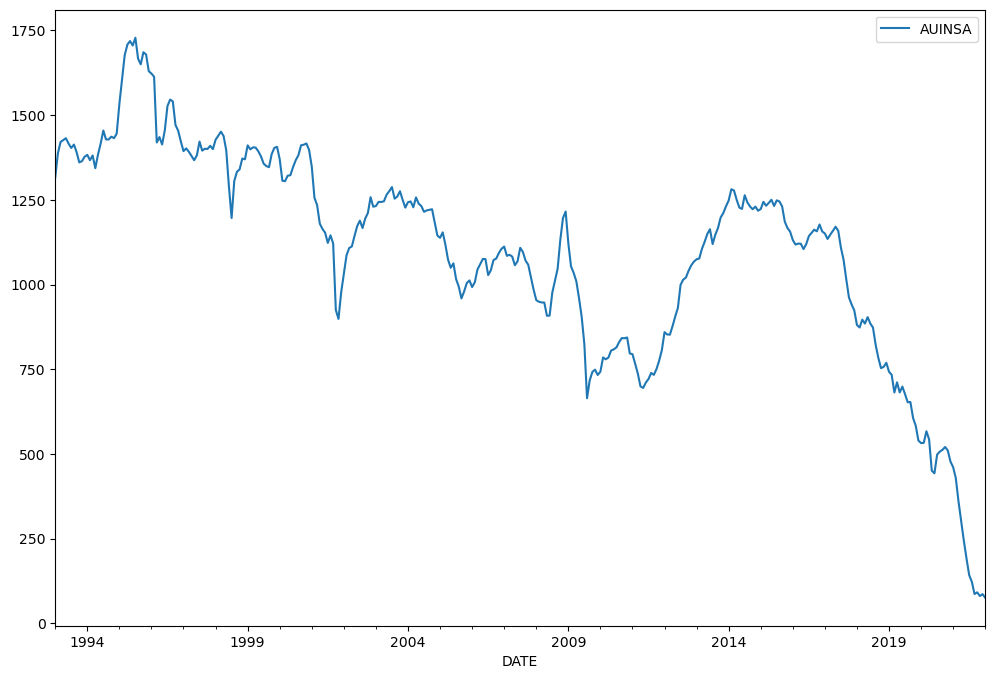

In [6]:
df.plot(figsize=(12,8))

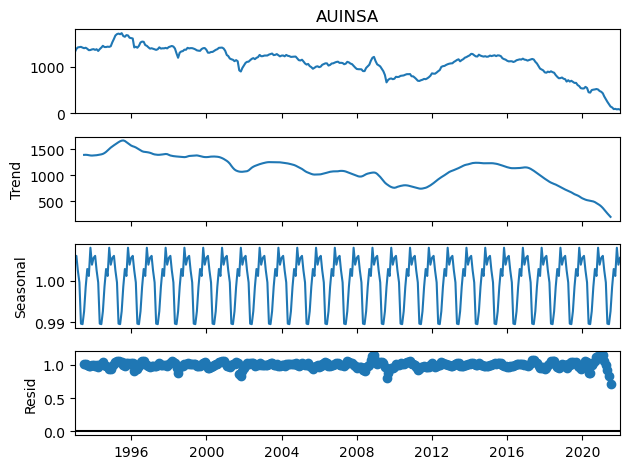

In [7]:
# check for seasonality and trend using ets decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['AUINSA'],model = 'multiplicative')
results.plot();

In [8]:
# let's confirm stationarity using augmented dickey-fuller-test
from statsmodels.tsa.stattools import adfuller
def adftest(series,title = ''):
  results = adfuller(series)
  labels = ['ADF statistics','p-value','# Lags','# Observations']
  op = pd.Series(results[:4],labels)
  for key,val in results[4].items():
    op[f'Crtical value for {(key)}'] = val
  print(op.to_string())
  if results[1]<=0.05:
    print('Strong evidence against null hypothesis')
    print('Reject null hypothesis')
    print('Data has no unit root and stationary')
  else:
    print('Weak evidence against null hypothesis')
    print('Failed to reject null hypothesis')
    print('Data has unit root and is non stationary')

In [9]:
adftest(df['AUINSA'])

ADF statistics             0.165197
p-value                    0.970241
# Lags                     1.000000
# Observations           347.000000
Crtical value for 1%      -3.449337
Crtical value for 5%      -2.869906
Crtical value for 10%     -2.571227
Weak evidence against null hypothesis
Failed to reject null hypothesis
Data has unit root and is non stationary


In [10]:
from pmdarima import auto_arima
auto_arima(df['AUINSA']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  349
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1714.580
Date:                Tue, 20 Feb 2024   AIC                           3433.161
Time:                        21:41:10   BIC                           3440.865
Sample:                    01-01-1993   HQIC                          3436.228
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3395      0.032     10.557      0.000       0.277       0.403
sigma2      1114.2030     40.324     27.632      0.000    1035.170    1193.236
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               675.73
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

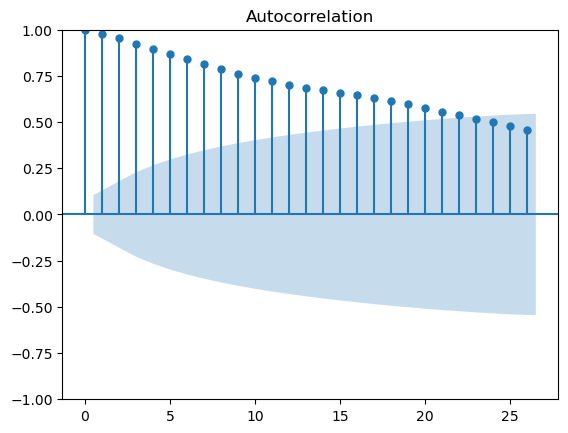

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['AUINSA']);

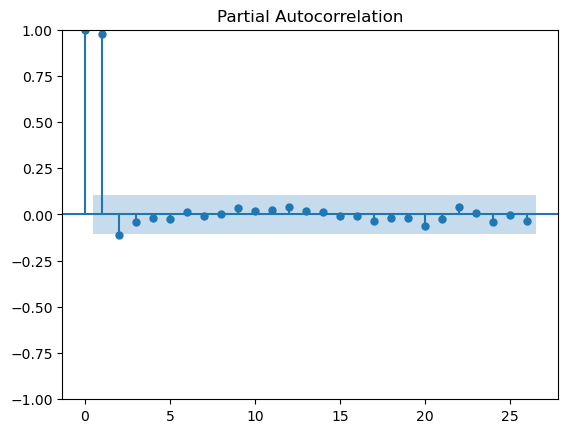

In [12]:
plot_pacf(df['AUINSA']);

In [13]:
len(df)

349

In [14]:
train= df.iloc[:301]
test = df.iloc[301:]
len(test)

48

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['AUINSA'],order =(1,1,0))
result = model.fit()

In [16]:
start = len(train)
end = start + len(test) - 1
test['Predicted_Values'] = result.predict(start=start,end=end)
test.head()

C:\Users\princ\AppData\Local\Temp\ipykernel_31020\1237454955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Values'] = result.predict(start=start,end=end)


,AUINSA,Predicted_Values
DATE,,
2018-02-01,873.344,866.040123
2018-03-01,896.643,870.849725
2018-04-01,884.936,904.553988
2018-05-01,903.942,880.960982
2018-06-01,885.167,910.395334


In [17]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test['AUINSA'],test['Predicted_Values'])
print(np.sqrt(rmse))

29.98600133655313


<Axes: xlabel='DATE'>

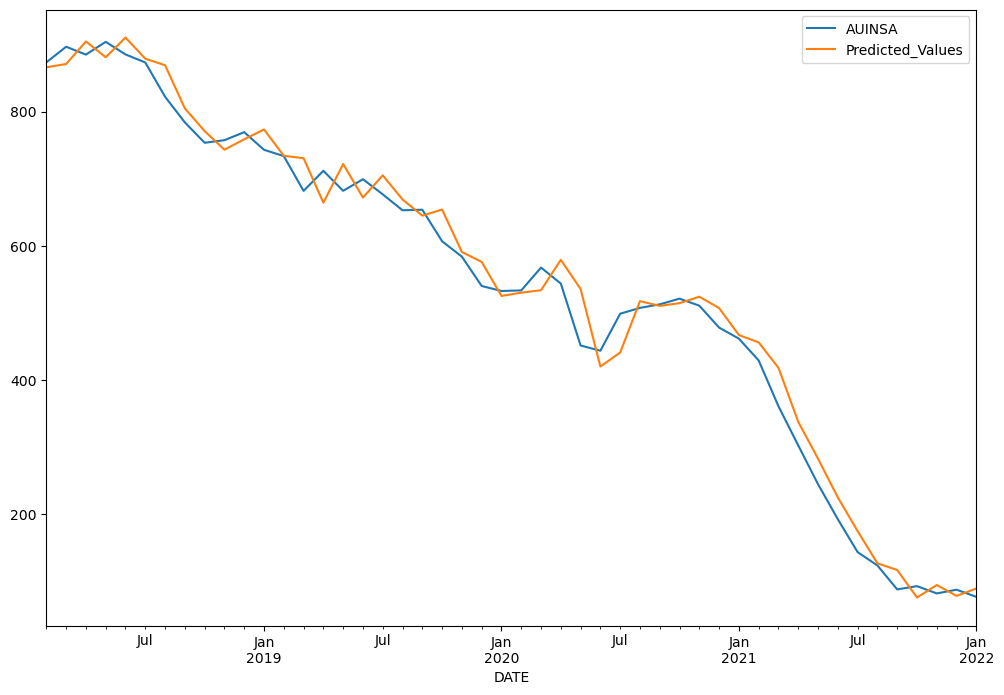

In [18]:
test['AUINSA'].plot(legend=True,figsize=(12,8))
test['Predicted_Values'].plot(legend=True)